Accepted moves: 65765
Rejected moves: 134235
Acceptance Ratio: 0.328825
Block sizes for U: [   10    20    40    80   160   320   640  1280  2560  5120 10240 20480
 40960 81920]
Average Potential Energy (U): -1.1743999759890894e-18 J
Average Potential Energy (U): (-1.1744±0.0013)×10⁻¹⁸ J
Specific Heat Capacity (c_V): 20.674802953285226 J/K/mol


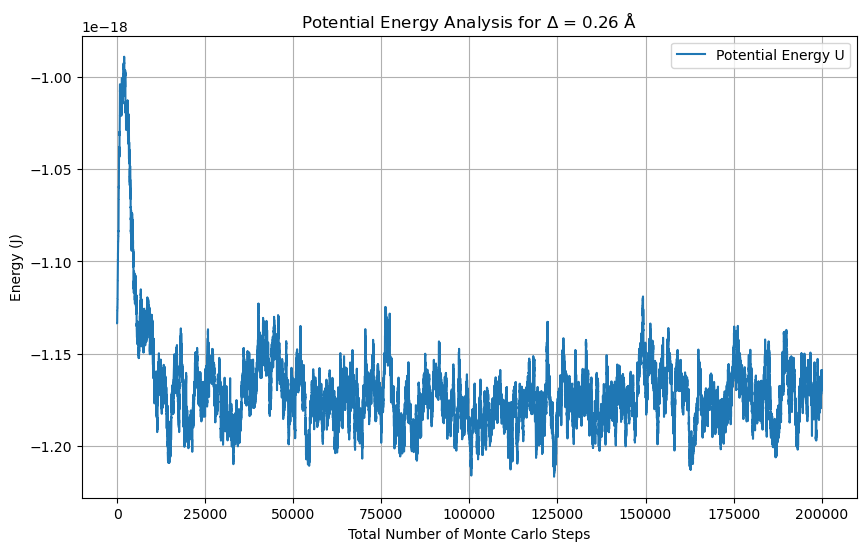

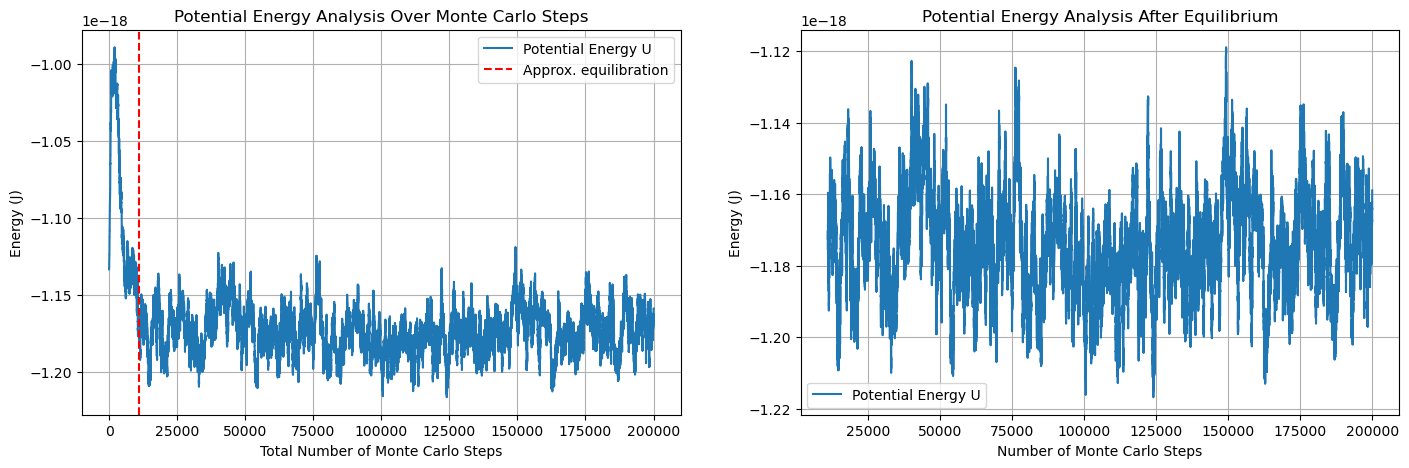

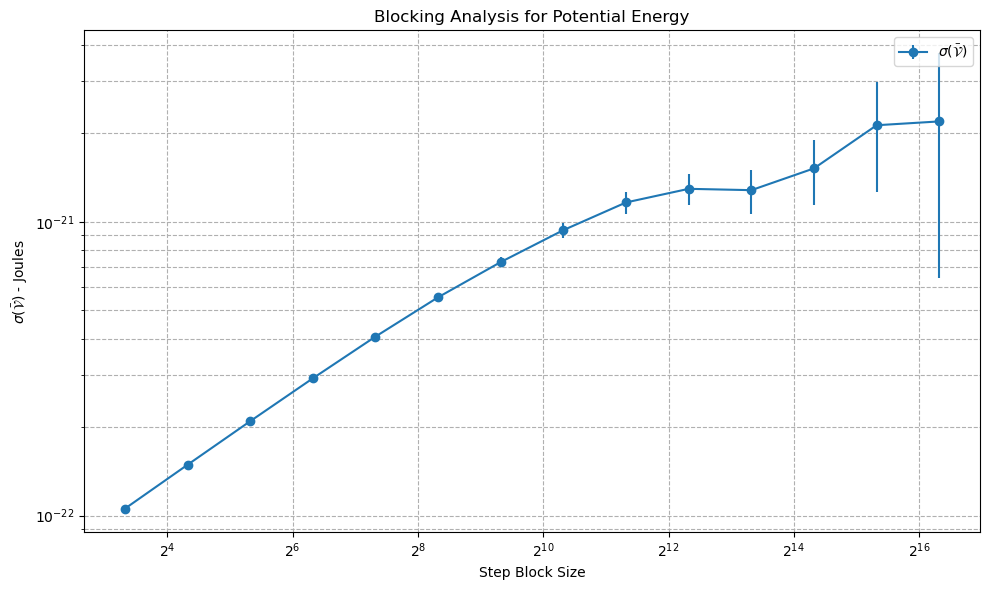

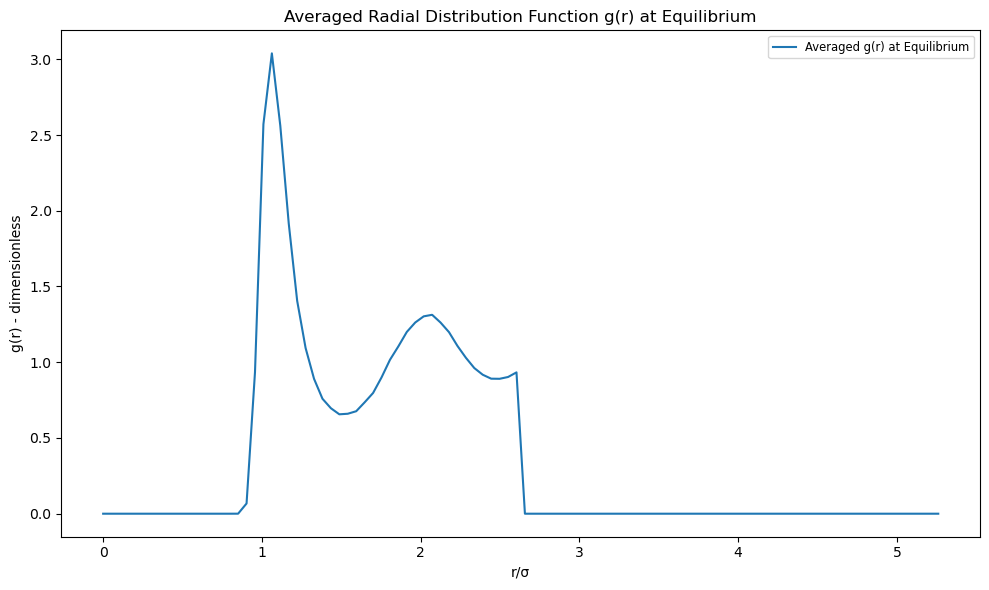

In [ ]:
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
from uncertainties import ufloat
from uncertainties import unumpy as unp


# Some constants for real unit conversion (Argon)
kB = 1.380649e-23  # J/K
SIGMA = 3.405  # Angstroms
EPSILON = 1.654e-21  # Joules (119.8K*kB)
AVOGADROS = 6.02214076e23 # mol^-1

# Minimum image convention for PBC:s
@njit
def minimum_image(r_vec, L):
    return r_vec-L*np.rint(r_vec/L)


# Apply Periodic Boundary Conditions
@njit
def apply_PBC(x, L):
    return x-L*np.floor(x/L)   # So we can keep the values within [0, L)


# Generate initial positions for n^3 atoms in a cubic lattice
@njit
def generate_lattice(n, L):
    d = L/n  # spacing
    positions = []
    for i in range(n):
        for j in range(n):
            for k in range(n):
                x = i*d
                y = j*d
                z = k*d
                positions.append([x, y, z])
    return np.array(positions)

# Compute potential energy
@njit
def PotentialEnergy(x, L):
    N = x.shape[0]
    U = 0.0
    for i in range(N-1):
            for j in range(i+1, N):
                r_vec = minimum_image(x[i] - x[j], L)
                r2 = np.dot(r_vec, r_vec)
                # Computing energy
                r2i = 1/r2
                r6i = r2i**3
                if r2 > 0:
                    U += 4*(r6i**2-r6i)
    return U


# Metropolis Monte Carlo function
@njit
def MC(x, steps, L, delta, n_bins):
    np.random.seed(42)
    N = x.shape[0] 
    h = np.zeros(n_bins, dtype=np.float64)  # Initialize histogram for RDF
    gs = []  # Store g_r at each step
    accepted = 0 # Accepted moves
    rejected = 0 # Rejected moves

    U = PotentialEnergy(x, L)
    U_traj = np.zeros(steps) # Preallocate storage arrays

    for step in range(steps):
        i = np.random.randint(N)
        old_x = x[i].copy()
        old_U = U

        # What substitutes: # Update position and apply PBC:s in MD
        x[i] += delta*(np.random.rand(3) - 0.5) # Trial Displacement (3.3.1 - Frenkel & Smit, pg. 43)
        x[i] = apply_PBC(x[i], L)

        new_U = PotentialEnergy(x, L)
        delta_U = new_U - old_U 

        # Accepts or rejects the move
        if delta_U < 0:
            accepted += 1
            # Update energy
            U += delta_U
        else:
            if np.random.rand() < np.exp(-(1/T_star)*delta_U): # Acceptance rule (3.2.1 - Frenkel & Smit, pg. 32)
                accepted += 1
                # Update energy
                U += delta_U
            else:
                rejected += 1
                x[i] = old_x
        
        # Compute histogram for RDF
        for i in range(N-1):
            for j in range(i+1, N):
                r_vec = minimum_image(x[i] - x[j], L)
                r2 = np.dot(r_vec, r_vec)
                r = np.sqrt(r2)
                dr = L/n_bins  # Bin width
                idx = int(r/dr) # Index: to which bin the distance belongs to 
                if r < L/2:  # Ensures r is in a valid range because of PBC:s 
                    idx = int(r/dr)  
                    if idx < n_bins:  
                        h[idx] += 1  # Count pair


        # Store values
        U_traj[step] = U

        # RDF
        h*= 2/N # Normalize histogram
        r_i = np.arange(0, n_bins)*dr # Distance to bins
        eps = 1e-15
        g_r = (L**3)/(N*4*np.pi*dr)*h/(r_i+eps)**2 #RDF formula
        #print(g_r)
        gs.append(g_r) # Append to a list


    acceptance_ratio = accepted/(accepted+rejected)

    return x, U_traj, acceptance_ratio, gs, accepted, rejected



########### Liquid Argon simulation for a target temp of 95 K and a density of 1.4 g/cm^3 #############################

# Calculate box size for target density
mass_atom = 39.948/AVOGADROS # g
density_real = 1.4  # g/cm^3
atoms_density = density_real/mass_atom  # atoms per cm^3

# Run simulation for 125 atoms
n=5
N = n**3
volume_cm3 = N/atoms_density
L_real = (volume_cm3**(1/3))*1e8  # convert cm to Å
L = L_real/SIGMA
delta = 0.26

# Temperature for simulation
target_temp = 95  # K
T_star = (kB*target_temp)/EPSILON

# Generate initial positions and velocities
x0 = generate_lattice(n, L)

# Run simulation for X steps
steps = 200000
x, U, acceptance_ratio, gs, accepted, rejected = MC(x0, steps, L, delta, n_bins=100)
print(f"Accepted moves: {accepted}")
print(f"Rejected moves: {rejected}")
print(f"Acceptance Ratio: {acceptance_ratio}")

# Convert to real units
#x_real = x * SIGMA
U_real = U * EPSILON

############################################################################################################



######## Plots and results #######:


#### Study of the System ####:

# Plot U for different deltas:

plt.figure(figsize=(10, 6))
plt.plot(np.arange(steps), U_real, label="Potential Energy U")
plt.xlabel("Total Number of Monte Carlo Steps")
plt.ylabel("Energy (J)")
plt.title("Potential Energy Analysis for " r'$\Delta$'" = 0.26 Å")
plt.legend()
plt.grid()



##### Analysis after equilibrium ######:

# Equilibrium range (e.g. after 5000 steps)
equilibrium_steps = range(11000, steps)
U_eq = U_real[equilibrium_steps]
average_U = np.mean(U_eq) # Average Potential Energy

# Plot total U and after equilibrium U
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(steps), U_real, label="Potential Energy U")
plt.axvline(x=11000, color='r', linestyle='--', label="Approx. equilibration")
plt.xlabel("Total Number of Monte Carlo Steps")
plt.ylabel("Energy (J)")
plt.title("Potential Energy Analysis Over Monte Carlo Steps")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(equilibrium_steps, U_eq, label= "Potential Energy U")
plt.xlabel("Number of Monte Carlo Steps")
plt.ylabel("Energy (J)")
plt.title("Potential Energy Analysis After Equilibrium")
plt.legend()
plt.grid()


##### Error Analysis ######:
def blocking_analysis(data):
    N = len(data)
    dblock = 2  # Each block size doubles
    block_sizes = []
    errors = []
    error_bars = []
    block_size = 10
    while block_size <= N // 2:
        num_blocks = N // block_size # n_b=n/k in compendium
        Ak_i=[]  #A^k_i compendium
        for i in range(num_blocks):

            block = data[i * block_size: (i + 1) * block_size]  # Select block
            Ak_i.append(np.mean(block))  # Compute mean of block


        mean_data = np.mean(data)  # Average of A
        variance = (1/num_blocks)*np.sum((np.array(Ak_i) - mean_data) **2)  # Equation 6 in compendium
        standard_error = np.sqrt(variance/(num_blocks - 1))  # Equation 8 in compendium
        error_bar = standard_error*ufloat(1, 1/np.sqrt(2*(num_blocks-1)))  # Equation 11 in compendium
    
        
        block_sizes.append(block_size)
        errors.append(standard_error)
        error_bars.append(error_bar)

        block_size *= dblock  # Double the block size

    return np.array(block_sizes), np.array(errors), np.array(error_bars)


block_sizes_U, std_errors_U, error_bars_U = blocking_analysis(U_eq)

# ufloats to nominal values and standard deviations
std_errors_U_nom = unp.nominal_values(error_bars_U)
std_errors_U_err = unp.std_devs(error_bars_U)

# Plot blocking with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(block_sizes_U, std_errors_U_nom, yerr=std_errors_U_err, fmt='o-', label = r'$\sigma(\mathcal{\bar{V}})$')
plt.xlabel("Step Block Size")
plt.ylabel(r'$\sigma(\mathcal{\bar{V}})$'" - Joules")
plt.title("Blocking Analysis for Potential Energy")
plt.xscale("log", base=2)
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()

print("Block sizes for U:", block_sizes_U)

# Choose block size that best fits when observing the plateau in the plot
plateau_index_U = np.where(block_sizes_U == 5120)[0][0]

# Get standard errors at plateau
error_U = std_errors_U_nom[plateau_index_U]
U_report = ufloat(average_U, error_U)

# Compute specific heat capacity c_V
u = U_eq/N # u (potential energy per atom)
sigma2_u = np.mean((u-np.mean(u))**2) 
c_V = ((3*kB)/2)+((N*sigma2_u)/(kB*(target_temp**2))) # Equation from compendium c_V for NVT
c_V*=AVOGADROS    

# Report calculations
print(f"Average Potential Energy (U): {average_U} J")
print(f"Average Potential Energy (U): {U_report:.2uP} J") # with errors
print(f"Specific Heat Capacity (c_V): {c_V} J/K/mol")

# Plot Averaged g(r) at equilibrium
g_r_avg = np.mean([gs[step] for step in equilibrium_steps], axis=0)
r_i = np.arange(0, len(g_r_avg))*(L/len(g_r_avg))
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(r_i, g_r_avg, label='Averaged g(r) at Equilibrium')
ax.set_xlabel('r/σ')
ax.set_ylabel('g(r) - dimensionless')
ax.set_title('Averaged Radial Distribution Function g(r) at Equilibrium')
ax.legend(loc='upper right', fontsize='small', ncol=1)
plt.tight_layout()


plt.show()